In [1]:
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import seaborn as sns

from dynamax.hidden_markov_model import LinearAutoregressiveHMM
from dynamax.utils.plotting import gradient_cmap
from dynamax.utils.utils import random_rotation

In [2]:
sns.set_style("white")
sns.set_context("talk")

color_names = [
    "windows blue",
    "red",
    "amber",
    "faded green",
    "dusty purple",
    "orange",
    "brown",
    "pink"
]

colors = sns.xkcd_palette(color_names)
cmap = gradient_cmap(colors)

In [ ]:
params, lls = model.fit_em(params, props, emissions=emissions, inputs = inputs, num_iters=100)

# Manual ARHMM

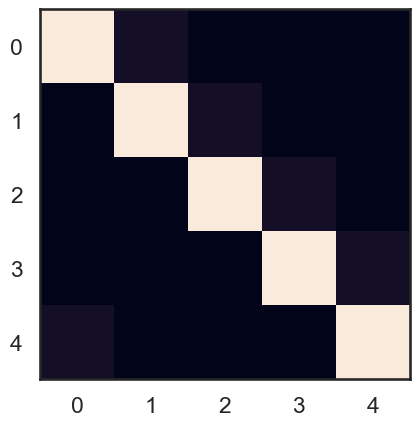

In [3]:
num_states = 5
transition_probs = (jnp.arange(num_states)**10).astype(float)
transition_probs /=transition_probs.sum()
transition_matrix = jnp.zeros((num_states, num_states))
for k, p in enumerate(transition_probs[::-1]):
    transition_matrix += jnp.roll(p * jnp.eye(num_states), k, axis=1)

plt.imshow(transition_matrix, vmin = 0)


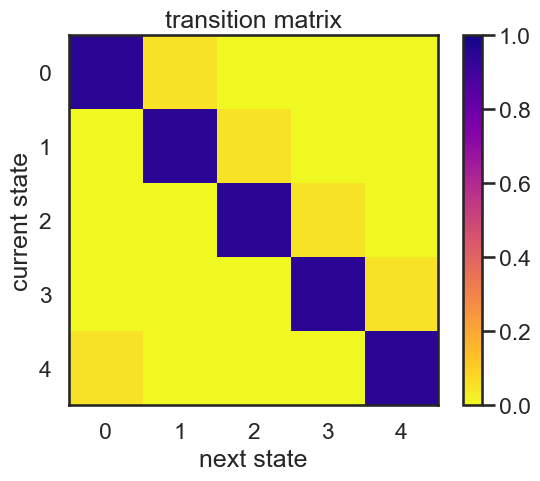

In [4]:
plt.imshow(transition_matrix, vmin=0, vmax=1, cmap="plasma_r")
plt.xlabel("next state")
plt.ylabel("current state")
plt.title("transition matrix")
plt.colorbar()

In [5]:
# Make observation distributions
emission_dim = 2
num_lags = 1

keys = jr.split(jr.PRNGKey(0), num_states)
angles = jnp.linspace(0, 2 * jnp.pi, num_states, endpoint=False)
theta = jnp.pi / 25 # rotational frequency
weights = jnp.array([0.8 * random_rotation(key, emission_dim, theta=theta) for key in keys])
biases = jnp.column_stack([jnp.cos(angles), jnp.sin(angles), jnp.zeros((num_states, emission_dim - 2))])
covariances = jnp.tile(0.001 * jnp.eye(emission_dim), (num_states, 1, 1))

# Compute the stationary points
stationary_points = jnp.linalg.solve(jnp.eye(emission_dim) - weights, biases)

/Users/mds8301/anaconda3/envs/transphorm/lib/python3.11/site-packages/jax/_src/numpy/linalg.py:1342: FutureWarning: jnp.linalg.solve: batched 1D solves with b.ndim > 1 are deprecated, and in the future will be treated as a batched 2D solve. Use solve(a, b[..., None])[..., 0] to avoid this warning.
  warnings.warn("jnp.linalg.solve: batched 1D solves with b.ndim > 1 are deprecated, "


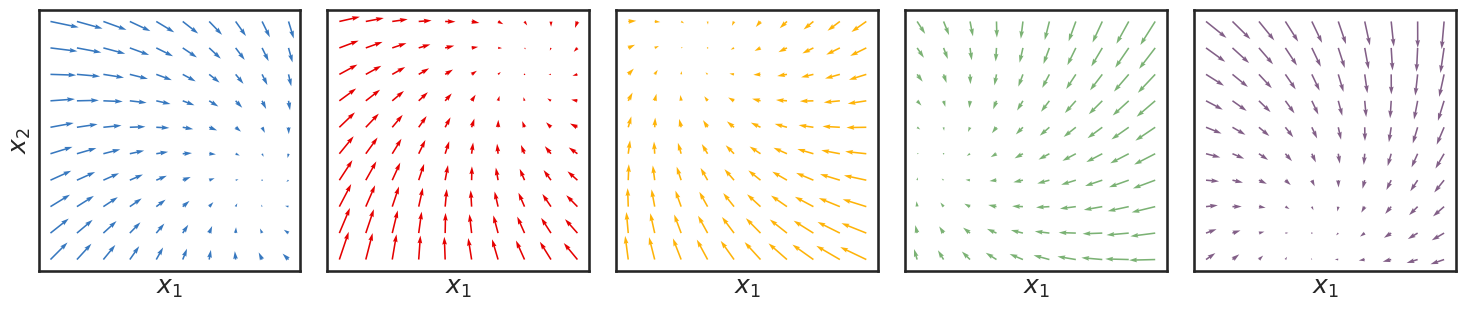

In [6]:
if emission_dim == 2:
    lim = 5
    x = jnp.linspace(-lim, lim, 10)
    y = jnp.linspace(-lim, lim, 10)
    X, Y = jnp.meshgrid(x, y)
    xy = jnp.column_stack((X.ravel(), Y.ravel()))

    fig, axs = plt.subplots(1, num_states, figsize=(3 * num_states, 6))
    for k in range(num_states):
        A, b = weights[k], biases[k]
        dxydt_m = xy.dot(A.T) + b - xy
        axs[k].quiver(xy[:, 0], xy[:, 1],
                    dxydt_m[:, 0], dxydt_m[:, 1],
                    color=colors[k % len(colors)])

        
        axs[k].set_xlabel('$x_1$')
        axs[k].set_xticks([])
        if k == 0:
            axs[k].set_ylabel("$x_2$")
        axs[k].set_yticks([])
        axs[k].set_aspect("equal")
                        

    plt.tight_layout()

In [7]:
true_arhmm = LinearAutoregressiveHMM(num_states, emission_dim, num_lags=num_lags)
true_params, true_prop = true_arhmm.initialize(initial_probs=jnp.ones(num_states)/num_states, 
                                               transition_matrix=transition_matrix, 
                                               emission_weights=weights, 
                                               emission_biases=biases, emission_covariances=covariances)

time_bins = 10000
true_state, emissions = true_arhmm.sample(true_params, jr.PRNGKey(0), time_bins)
inputs = true_arhmm.compute_inputs(emissions)

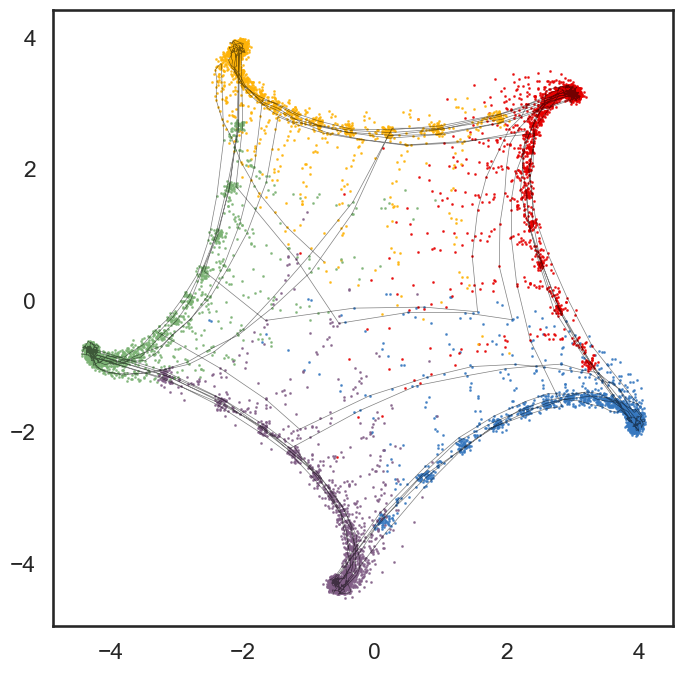

In [8]:
fig = plt.figure(figsize=(8,8))
for k in range(num_states):
    plt.plot(*emissions[true_state==k].T, 'o', color = colors[k], alpha=0.75, markersize = 1)
plt.plot(*emissions[:1000].T, '-k', lw = 0.5, alpha = 0.5)

In [9]:
Ey = jnp.array(stationary_points)[true_state]

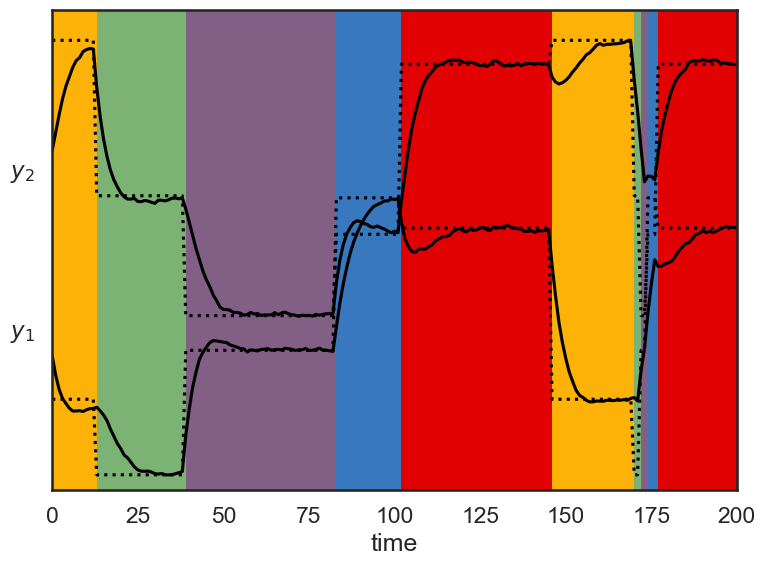

In [10]:
plot_slice = (0,200)
lim = 1.05*abs(emissions).max()
plt.figure(figsize = (8,6))
plt.imshow(true_state[None, :],
            aspect="auto",
              cmap=cmap, 
              vmin=0, 
              vmax=len(colors)-1, 
              extent = (0, time_bins, -lim, (emission_dim)*lim))
for d in range(emission_dim):
    plt.plot(emissions[:,d] + lim * d, '-k')
    plt.plot(Ey[:,d] + lim * d, ':k')

plt.xlim(plot_slice)
plt.xlabel("time")
plt.yticks(lim * jnp.arange(emission_dim), ["$y_{{{}}}$".format(d+1) for d in range(emission_dim)])

plt.tight_layout()

In [11]:
# Now fit an HMM to the emissions
key1, key2 = jr.split(jr.PRNGKey(0), 2)
test_num_states = num_states

# Initialize with K-Means
arhmm = LinearAutoregressiveHMM(num_states, emission_dim, num_lags=num_lags)
params, props = arhmm.initialize(key=jr.PRNGKey(1), method="kmeans", emissions=emissions)

# Fit with EM
fitted_params, lps = arhmm.fit_em(params, props, emissions, inputs=inputs)

In [14]:
inputs.shape

(10000, 2)

In [15]:
emissions.shape

(10000, 2)